Model: "U_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
[[8.07437]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 8.0744
Epoch 2/3000
[[8.00575829]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.0058
Epoch 3/3000
[[7.94226074]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9423
Epoch 4/3000
[[7.88399792]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8840
Epoch 5/3000
[[7.83069324]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8307
Epoch 6/3000
[[7.78159714]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.7816
Epoch 7/3000
[[7.73561811]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.7356
Epoch 8/3000
[[7.69155312]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6916
Epoch 9/3000
[[7.64835644]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.6484
Epoch 10/3000
[[7.60526752]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.6053
Epoch 11/3000
[[7.56180286]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.5618
Epoch 12/3000
[[7.51766968]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.5177
Epoch 13/3000
[[7.47270489]]
1

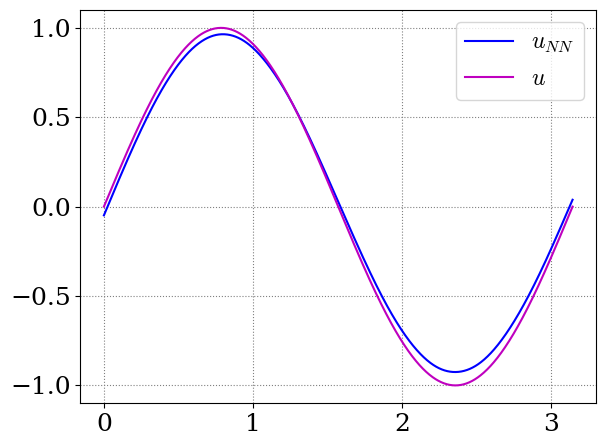

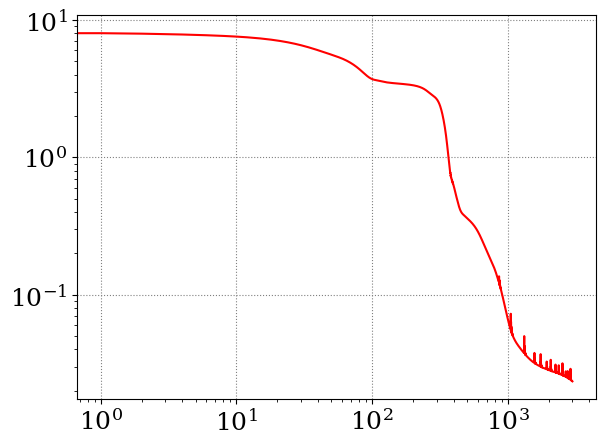

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Define the number of neuron per layer
NN = 10
#Define the number of layers 
NL = 5
#Define number of collocation points
N_points = 100
# Define the number of epochs
N_epoch = 3000
#Define the source
def f_source(x):
    return -4*tf.sin(2*x)
def uexact(x):
    return tf.sin(2*x)


#Input dummy
X = tf.keras.layers.Input(shape = (1,))

#Define the first layer with dummy input
L1 = tf.keras.layers.Dense(units=NN, activation = 'tanh')(X)

#Feed the first layer to a generic layer for the number of layers, without the first and last layers
for l in range(NL - 2):
    L1 = tf.keras.layers.Dense(units=NN, activation = 'tanh')(L1)

#Last layer after being fed with the second to last layer (1 output)
LO = tf.keras.layers.Dense(units=1, activation = 'tanh')(L1)

#Assembly the model
U_model = tf.keras.Model(inputs = X, outputs = LO, name = 'U_model')
#model summary
U_model.summary()


#Define a class for the loss, we are going to call this class in every iteration, evaluating this on the randomized sample, the target function and the output of the network
###############################################################################
#Parameters for the class "loss": U_model --> Neural Network Architecture     #
#           N_points --> Number of Sampled points across the problem's domain #
#           f_source --> Source function on the PDE -Δu = f                   #
###############################################################################

class loss(tf.keras.layers.Layer):

    def __init__(self, U_model, N_points,f_source, **kwargs):
        super(loss,self).__init__()
        self.U_model = U_model
        self.N_points = N_points
        self.f_source = f_source
    #Compute the second derivative of the neural network U_nn
    def  call(self,inputs):
        S = tf.experimental.numpy.linspace(0.,np.pi,num=self.N_points, dtype='float32')
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(S)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(S)
                ueval = U_model(S)
                u_x = t2.gradient(ueval,S)
            u_xx = t1.gradient(u_x,S)   
    
        #Assemble the residual loss & the loss for the collocation points
        f_source = self.f_source(S)
        loss_out = tf.math.reduce_mean((u_xx - f_source)**2) + self.U_model(np.array([0.]))**2 + self.U_model(np.array([np.pi]))**2 
        tf.print(loss_out)
        return loss_out    

#Tell tensorlofw to recognize this class as a loss
def loss_model(U_model,N_points, f_source):
    Xl = tf.keras.layers.Input(shape = (1,))
    loss_layer = loss(U_model, N_points, f_source)(Xl)
    loss_f = tf.keras.Model(inputs = Xl, outputs = loss_layer)
    return loss_f


def loss_value(x,y):
    return y

#Assemble the model
model_all = loss_model(U_model, N_points, f_source)
optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-3)
model_all.compile(optimizer = optimizer, loss = loss_value)

#Train the model
history = model_all.fit(np.array([1.]),np.array([1.]),epochs = N_epoch)


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 17
rcParams['mathtext.fontset'] = 'cm' 
rcParams['axes.labelsize'] = 19


# Generate a list of x values for visualization
xlist = tf.experimental.numpy.linspace(0.,np.pi,num=1000, dtype='float32')

## ---------
# Graph the Solution
## ---------

fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(xlist, U_model(xlist), color='b')
plt.plot(xlist, uexact(xlist), color='m')

plt.legend(['$u_{NN}$', '$u$'])

ax.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()
Loss_rel = history.history['loss'] 
fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(Loss_rel, color='r')


ax.set_xscale('log')
ax.set_yscale('log')



ax.grid(which = 'major', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()


